In [10]:
# Step 1: Load MobileNet as a feature extractor
base_model = MobileNet(weights='imagenet', include_top=False)

# Add a Global Average Pooling layer to extract features
x = base_model.output
x = GlobalAveragePooling2D()(x)
feature_extractor = Model(inputs=base_model.input, outputs=x)

# Freeze the layers of MobileNet to use it as a feature extractor
for layer in base_model.layers:
    layer.trainable = False

# Step 2: Extract features for training and testing data
def extract_features(data_generator):
    features = []
    labels = []
    
    # Loop through batches of images and extract features
    for images, batch_labels in data_generator:
        # Extract features from the MobileNet model
        feature_batch = feature_extractor.predict(images)
        features.append(feature_batch)
        labels.append(batch_labels)
        
        # If we have enough data, stop
        if len(features) * data_generator.batch_size >= data_generator.samples:
            break
    
    # Convert to numpy arrays
    features = np.vstack(features)
    labels = np.vstack(labels)
    return features, labels

# Extract features for train data
X_train_features, y_train_labels = extract_features(train_data_gen)

# Extract features for test data
X_test_features, y_test_labels = extract_features(test_data_gen)

# Step 3: Save the extracted features to .joblib files
joblib.dump((X_train_features, y_train_labels), 'train.joblib')
joblib.dump((X_test_features, y_test_labels), 'test.joblib')

# Step 4: Split the training data into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_features, y_train_labels, test_size=0.2, random_state=42
)

# Optionally, save the split data to .joblib files
joblib.dump((X_train, y_train), 'train_split.joblib')
joblib.dump((X_val, y_val), 'val_split.joblib')

# Saved in 'train.joblib' and 'test.joblib'
print("Features extracted and saved to 'train.joblib' and 'test.joblib'.")



1/1 [==============================] - 0s 400ms/step
Features extracted and saved to 'train.joblib' and 'test.joblib'.


---
# 3. Mobilenet Model
<span id="Importmodules"></span>

---

In [11]:
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input


# Load the features extracted previously
X_train_features, y_train_labels = joblib.load('train_split.joblib')
X_val, y_val = joblib.load('val_split.joblib')
X_test_features, y_test_labels = joblib.load('test.joblib')

# If the labels are not already one-hot encoded, we can one-hot encode them
num_classes = y_train_labels.shape[1]  

input_shape = X_train_features.shape[1]  # The number of features per sample (1024 in this case)

# Define the model for classification
input_layer = Input(shape=(input_shape,))  # This is the shape of the features (1024,)
x = Dropout(0.5)(input_layer)  # Dropout to reduce overfitting
x = Dense(1024, activation='relu')(x)  # Fully connected layer with ReLU activation
x = Dropout(0.5)(x)  # Another Dropout layer
output_layer = Dense(num_classes, activation='softmax')(x)  # Output layer with softmax for multi-class classification

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_features, y_train_labels, 
                    epochs=5, batch_size=32, 
                    validation_data=(X_val, y_val))


Epoch 1/5


41/41 [==============================] - 3s 28ms/step - loss: 2.5130 - accuracy: 0.3224 - val_loss: 0.7625 - val_accuracy: 0.8379
Epoch 2/5
41/41 [==============================] - 1s 18ms/step - loss: 0.9082 - accuracy: 0.7113 - val_loss: 0.3178 - val_accuracy: 0.9174
Epoch 3/5
41/41 [==============================] - 1s 20ms/step - loss: 0.5877 - accuracy: 0.8032 - val_loss: 0.2037 - val_accuracy: 0.9450
Epoch 4/5
41/41 [==============================] - 1s 18ms/step - loss: 0.4081 - accuracy: 0.8606 - val_loss: 0.1967 - val_accuracy: 0.9235
Epoch 5/5
41/41 [==============================] - 1s 19ms/step - loss: 0.3422 - accuracy: 0.8851 - val_loss: 0.0989 - val_accuracy: 0.9847


---
# 4. Plot training and validation accuracy
<span id="Importmodules"></span>

---

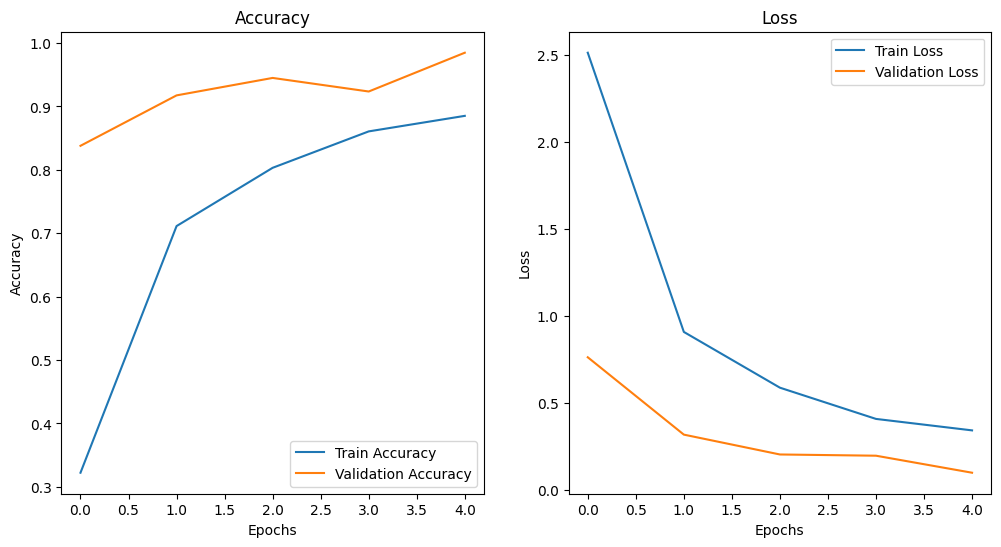

In [12]:
# Plot accuracy and loss
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [14]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_features, y_test_labels, verbose=1)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Make predictions on the test set
y_pred = model.predict(X_test_features)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_labels, axis=1)

6/6 [==============================] - 0s 5ms/step - loss: 0.0538 - accuracy: 0.9945
Test accuracy: 0.9945
Test loss: 0.0538
6/6 [==============================] - 0s 4ms/step


---
# 5. Confusion Matrix and Classification Report
<span id="Importmodules"></span>

---

Confusion Matrix:
[[7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 6 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0

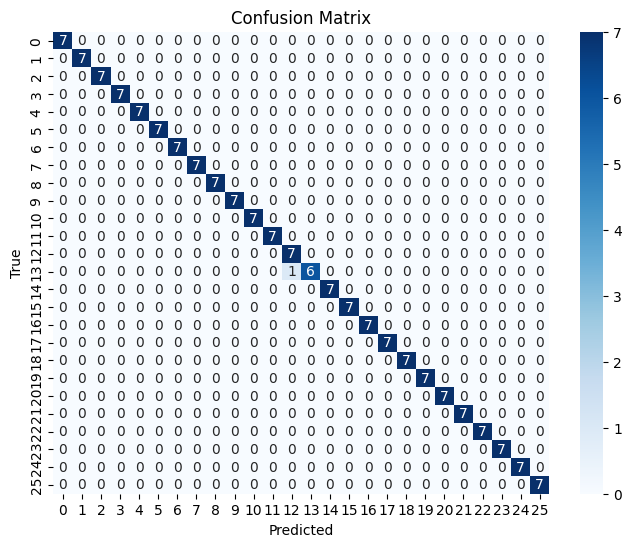

In [15]:

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_true_classes, y_pred_classes)
print("Classification Report:")
print(class_report)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()